## 1. Setup and Preprocessing

In [1]:
import sys
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import gc
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [3]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
    else:
        print("CUDA is not available. Using CPU.")

check_cuda()

CUDA is available. Using GPU: NVIDIA A100-SXM4-40GB


In [4]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [6]:
#  !pip install evaluate

In [8]:
#  !pip install -U bitsandbytes

In [9]:
# exit()

In [11]:
# !apt-get install -y ninja-build

In [12]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast
import os


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login

In [27]:
import os
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the working directory to the NLP folder in your Drive
nlp_folder = Path('/content/drive/My Drive/NLP')
os.chdir(nlp_folder)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Define the base path (now the NLP folder)
basepath = nlp_folder

# Create the data folder, model folder, and custom functions folder
data_folder = Path(basepath) / 'data_folder'
model_folder = Path(basepath) / 'lect 7' / 'assignment 7'/ 'sentiment' / 'nn' # Updated path
custom_functions = Path(basepath) / 'lect 7' / 'assignment 7' /'CustomFiles'  # Updated path

# Create the necessary directories if they don't exist
model_folder.mkdir(exist_ok=True, parents=True)
custom_functions.mkdir(exist_ok=True, parents=True)

# Verify that the folders are created
print(f"Model folder created: {model_folder.exists()}")
print(f"Custom functions folder created: {custom_functions.exists()}")

In [28]:
set_seed(69)

In [29]:
model_folder.mkdir(exist_ok=True, parents = True)

In [30]:
import wandb

# Log into WandB
wandb.login()

wandb: Currently logged in as: shobhit-pachauri (shobhit-pachauri-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


True

In [31]:
from huggingface_hub import login

login()

In [32]:
model_folder

PosixPath('/content/drive/My Drive/NLP/lect 7/assignment 7/sentiment/nn')

In [33]:
import pandas as pd
import numpy as np
train_dataset = pd.read_csv(data_folder /'train.csv',usecols=lambda column: column != 'ID')

In [34]:
type(train_dataset)

pandas.core.frame.DataFrame

In [35]:
train_dataset.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [36]:
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [37]:
len(label_columns)

11

In [38]:
selected_columns = {
    'text': train_dataset['Tweet'],
    'label': train_dataset[label_columns].values.tolist()}

tweet_selected_columns = Dataset.from_dict(selected_columns)

In [39]:
tweet_selected_columns.set_format(type='pandas')

In [40]:
df = tweet_selected_columns[:]

In [41]:
df

,text,label
0,“Worry is a down payment on a problem you may ...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]"
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
7719,@BadHombreNPS @SecretaryPerry If this didn't m...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
7720,Excited to watch #stateoforigin tonight! Come ...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
7721,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
7722,#ThingsIveLearned The wise #shepherd never tru...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [42]:
df_final = Dataset.from_pandas(df)

In [43]:
df_final

Dataset({
    features: ['text', 'label'],
    num_rows: 7724
})

In [44]:
test_val_splits = df_final.train_test_split(test_size=0.3, seed=36)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=36)
val_split = test_val_splits['train']
test_split = test_val_splits['test']

In [45]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [46]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1159
    })
})

## 2. Tokenization

In [47]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [48]:
free_gpu_memory()

In [49]:
checkpoint = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [50]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

In [51]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [52]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1159
    })
})

In [53]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [54]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 1159
    })
})

In [55]:
tokenized_dataset['train']['label'][0:5]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## 3. Model Download

In [56]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [57]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [58]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [59]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
config.id2label = id2label
config.label2id = label2id
model.config = config

## 4. PEFT Setup

In [61]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention

In [62]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [63]:
find_linear_layers(model)

['k_proj',
 'q_proj',
 'score',
 'o_proj',
 'v_proj',
 'up_proj',
 'down_proj',
 'gate_proj']

In [64]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                 # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",         # NormalFloat (nf4) quantization type for QLoRA
    bnb_4bit_use_double_quant=True     # Double quantization for additional memory efficiency
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

In [65]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleD

In [66]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## 5. Training and Validation

In [67]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [127]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/Gemma")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'multilabel_tweet_hw7_gemma'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 69,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [128]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

GemmaConfig {
  "_name_or_path": "google/gemma-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu",
  "hidden_activation": null,
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "rop

In [129]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [130]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [131]:
pos_weights

tensor([ 1.6882,  6.0945,  1.6487,  4.6489,  1.6896,  8.2568,  2.4433,  7.5538,
         2.3268, 17.3878, 18.1025])

In [132]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [133]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [134]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-134-205d00a764b3>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


## 4. Validation

In [78]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [79]:
eval_results

{'eval_loss': 0.7589457035064697,
 'eval_f1_micro': 0.6425914445133292,
 'eval_f1_macro': 0.568180013104879,
 'eval_accuracy_label': 0.819123068475959,
 'eval_accuracy_all': 0.12510785159620363,
 'eval_runtime': 4.2768,
 'eval_samples_per_second': 270.997,
 'eval_steps_per_second': 8.651,
 'epoch': 2.0}

In [80]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

In [81]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [82]:
valid_logits.shape

(1159, 11)

## 5. Optimizing Thresholds and Accounting for Imbalance

In [83]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics

In [84]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [85]:
optimal_thresholds

[0.5288375616073608,
 0.4891679584980011,
 0.5607337951660156,
 0.6001882553100586,
 0.5127536058425903,
 0.7512826919555664,
 0.46465879678726196,
 0.5591697096824646,
 0.4246506094932556,
 0.8086715936660767,
 0.5422571897506714]

In [86]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [87]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.6610905581470162,
 'f1_macro': 0.5879948423132129,
 'accuracy_label': 0.8347321358537925,
 'accuracy_all': 0.15012942191544434}

## 6. Confusion Matrix

In [88]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

In [89]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

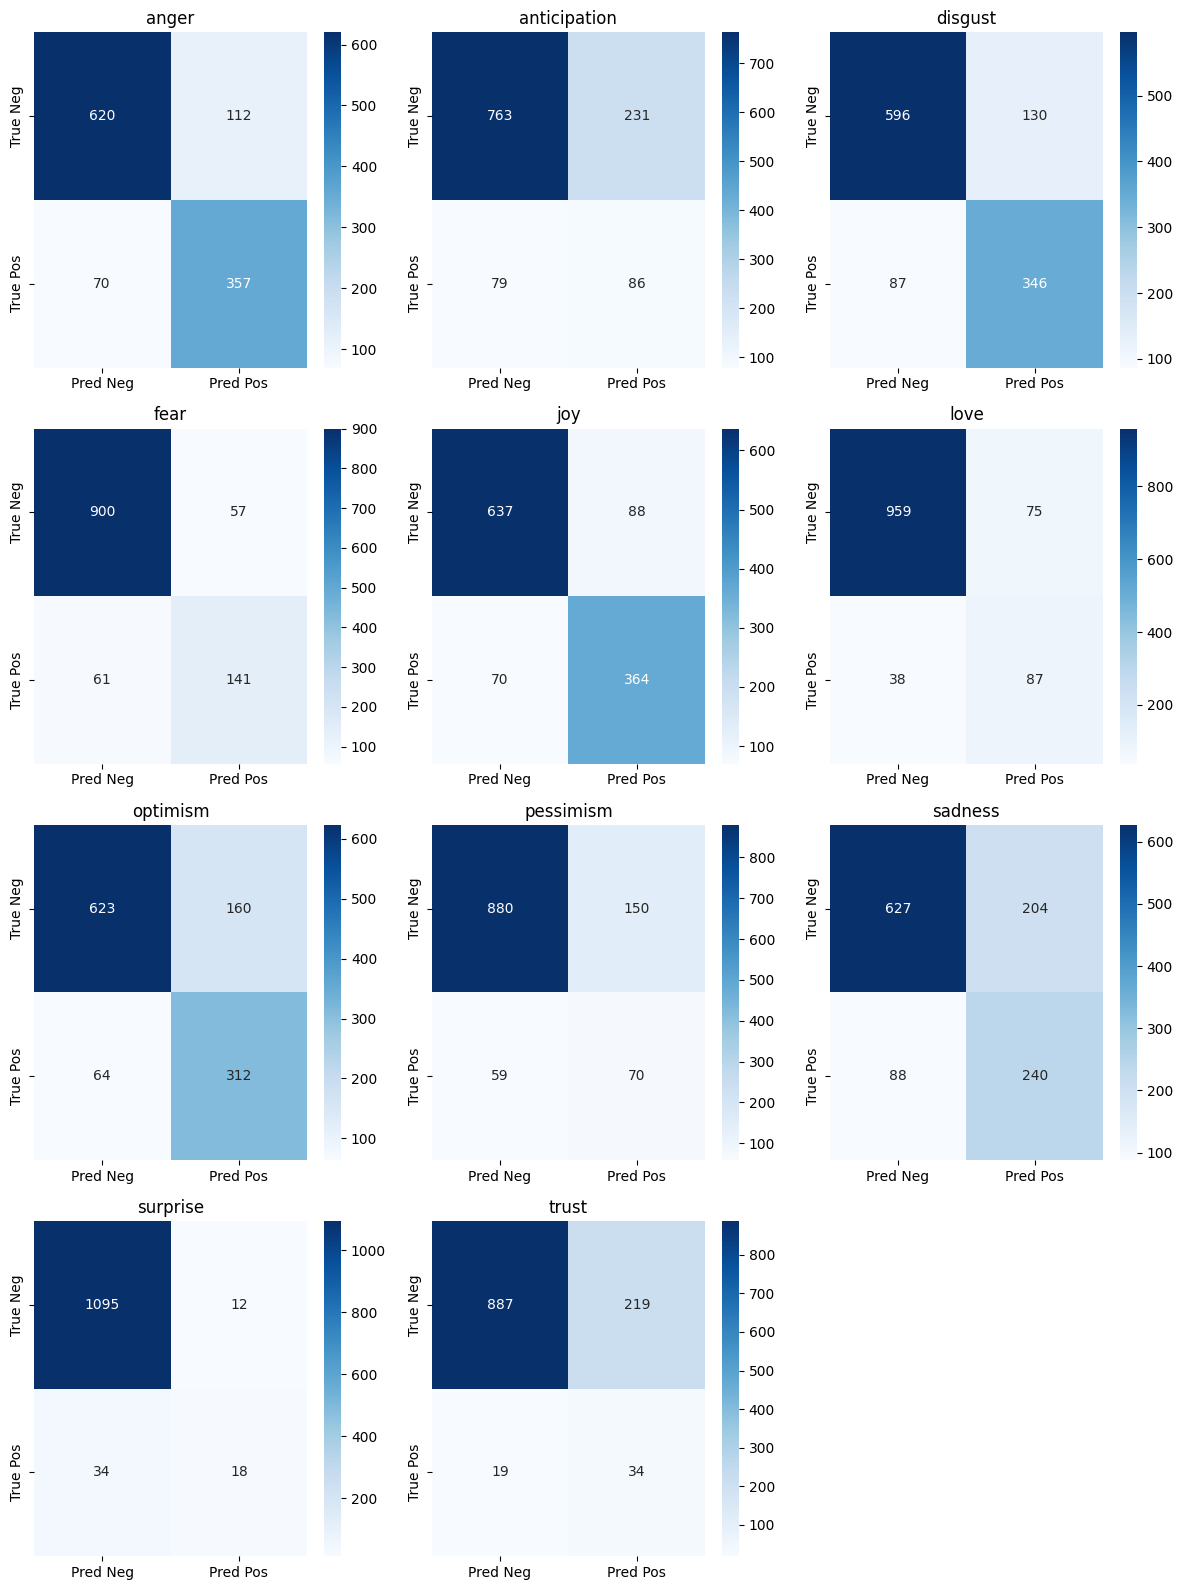

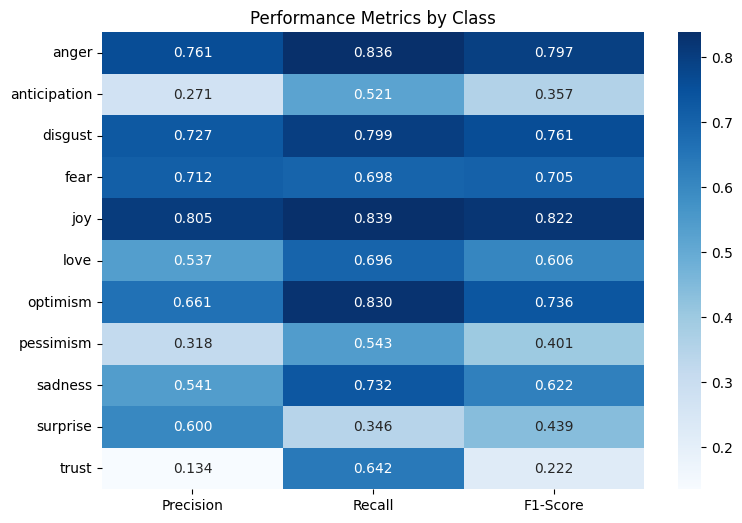

<Figure size 1200x533.333 with 0 Axes>

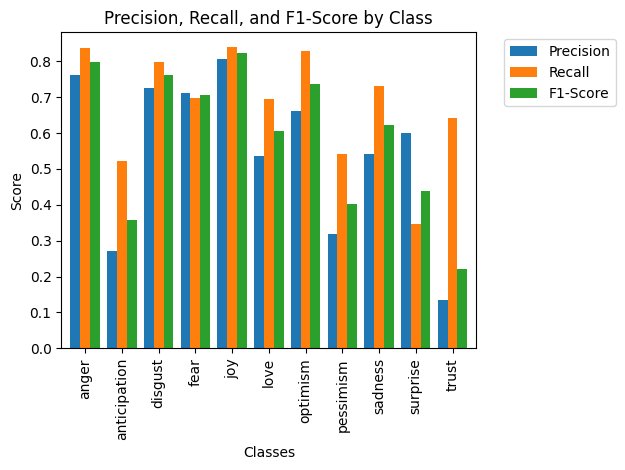

{'macro_avg': {'precision': 0.5516338913520609,
  'recall': 0.6800797160908963,
  'f1': 0.5879948423132129},
 'per_class': {'Precision': {'anger': 0.7611940298507462,
   'anticipation': 0.27129337539432175,
   'disgust': 0.726890756302521,
   'fear': 0.7121212121212122,
   'joy': 0.8053097345132744,
   'love': 0.5370370370370371,
   'optimism': 0.6610169491525424,
   'pessimism': 0.3181818181818182,
   'sadness': 0.5405405405405406,
   'surprise': 0.6,
   'trust': 0.13438735177865613},
  'Recall': {'anger': 0.8360655737704918,
   'anticipation': 0.5212121212121212,
   'disgust': 0.7990762124711316,
   'fear': 0.698019801980198,
   'joy': 0.8387096774193549,
   'love': 0.696,
   'optimism': 0.8297872340425532,
   'pessimism': 0.5426356589147286,
   'sadness': 0.7317073170731707,
   'surprise': 0.34615384615384615,
   'trust': 0.6415094339622641},
  'F1-Score': {'anger': 0.796875,
   'anticipation': 0.35684647302904565,
   'disgust': 0.7612761276127613,
   'fear': 0.705,
   'joy': 0.8216

In [90]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=label_columns, figsize=(12, 8))

## 7. Saving the Best Model

In [91]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

In [92]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/Gemma/checkpoint-520'

## 8. Performance on Test Set

In [93]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [94]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
model.config.id2label = id2label
model.config.label2id = label2id


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [96]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1159
})

In [97]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [98]:
training_args = TrainingArguments(
    seed = 36,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [99]:
from functools import partial
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [100]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-100-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [101]:
test_results= trainer.evaluate()

In [102]:
test_results

{'eval_loss': 0.7542861700057983,
 'eval_model_preparation_time': 0.0055,
 'eval_f1_micro': 0.6622687047465808,
 'eval_f1_macro': 0.5797424553972778,
 'eval_accuracy_label': 0.8353596360498863,
 'eval_accuracy_all': 0.16393442622950818,
 'eval_runtime': 2.6088,
 'eval_samples_per_second': 444.27,
 'eval_steps_per_second': 3.833}

In [103]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

In [104]:
test_output = trainer.predict(test_set_tokenized)

In [105]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))

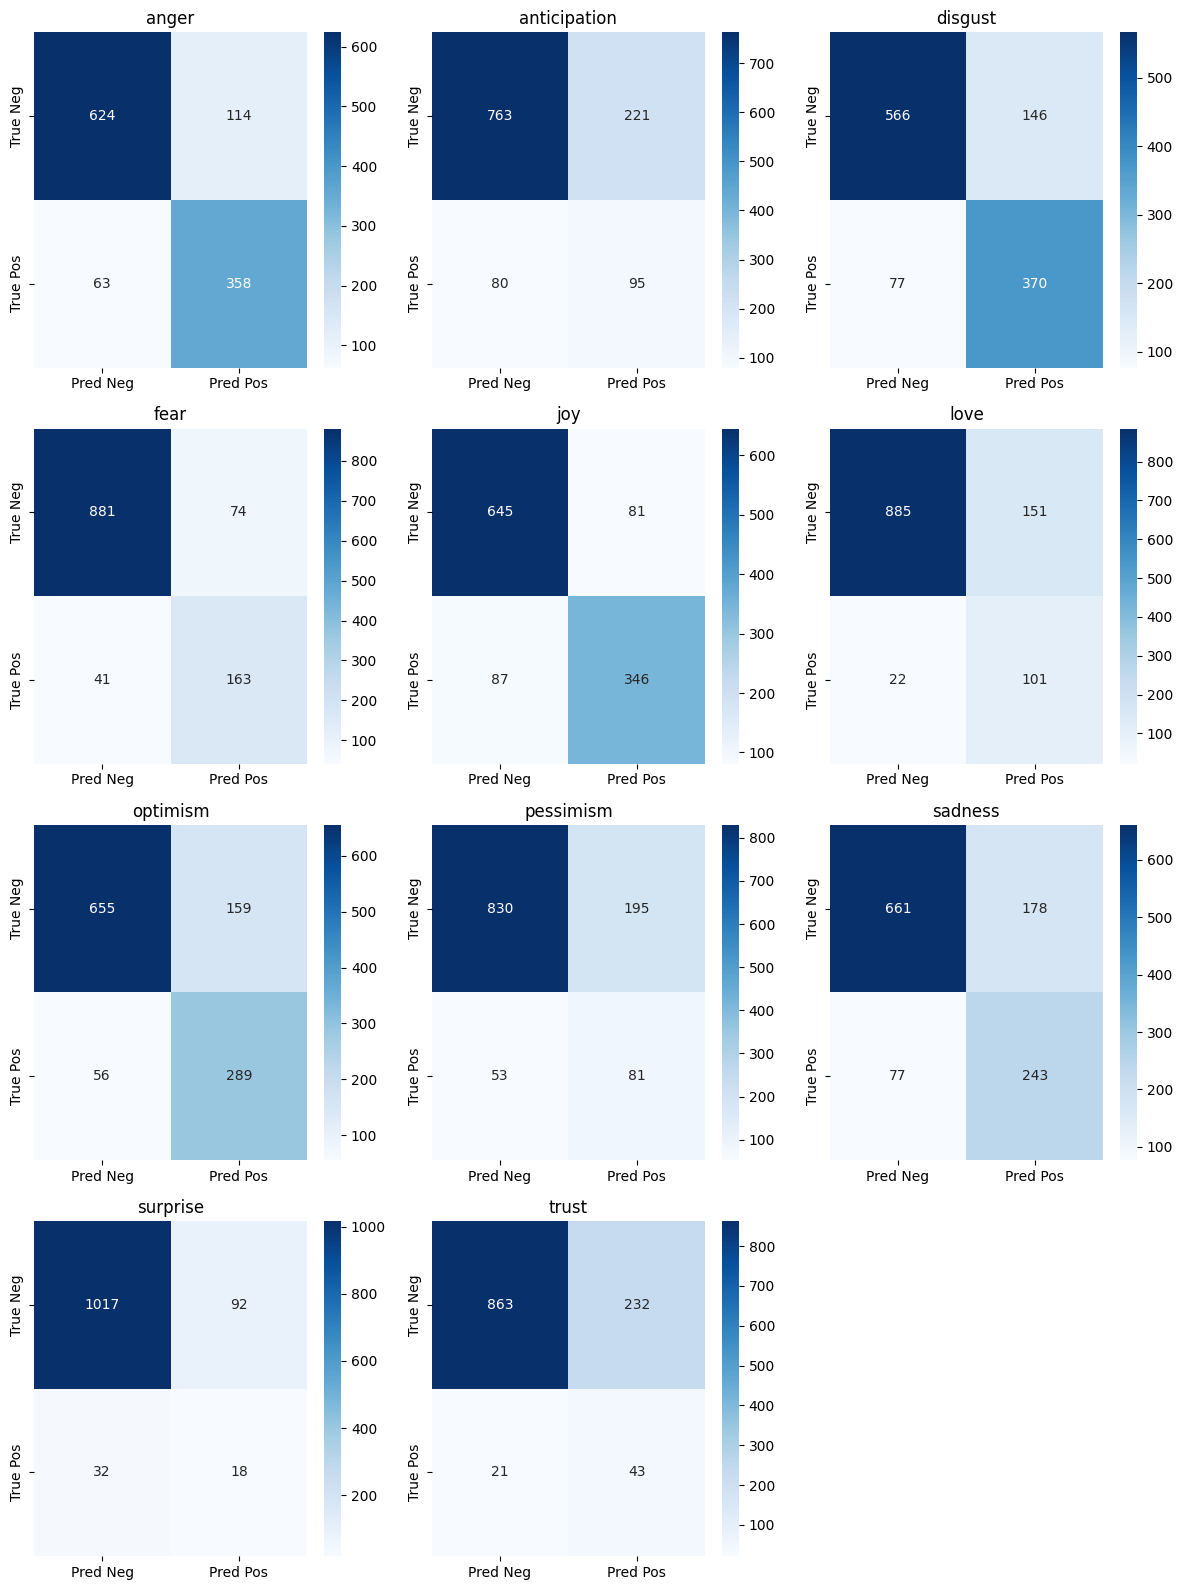

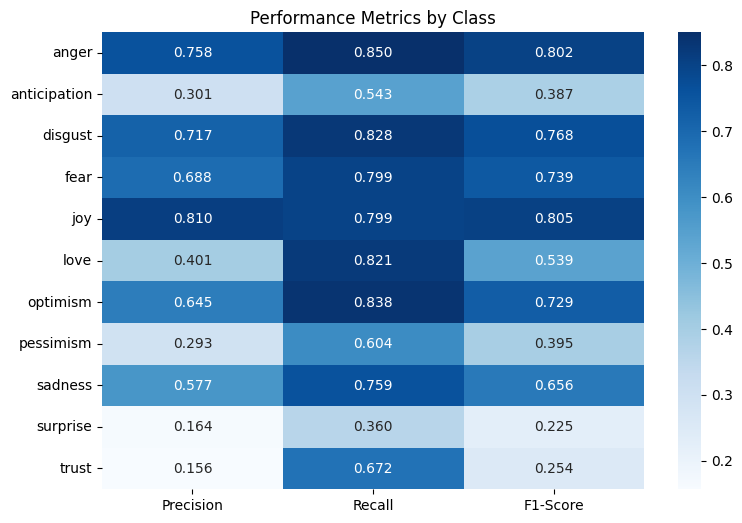

<Figure size 1200x533.333 with 0 Axes>

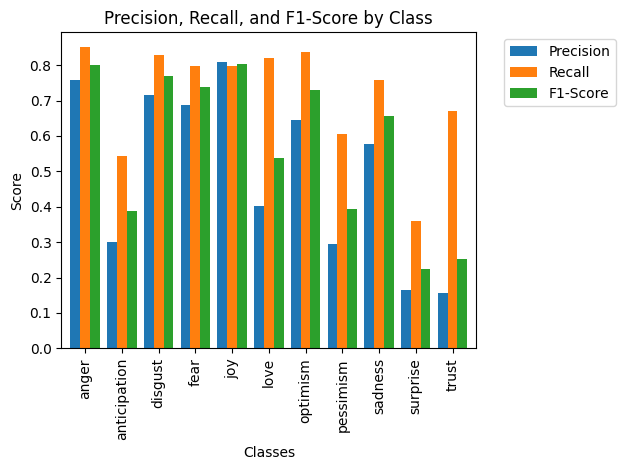

{'macro_avg': {'precision': 0.5009807509981429,
  'recall': 0.7157815211473595,
  'f1': 0.5725721199808261},
 'per_class': {'Precision': {'anger': 0.7584745762711864,
   'anticipation': 0.30063291139240506,
   'disgust': 0.7170542635658915,
   'fear': 0.6877637130801688,
   'joy': 0.810304449648712,
   'love': 0.4007936507936508,
   'optimism': 0.6450892857142857,
   'pessimism': 0.29347826086956524,
   'sadness': 0.5771971496437055,
   'surprise': 0.16363636363636364,
   'trust': 0.15636363636363637},
  'Recall': {'anger': 0.850356294536817,
   'anticipation': 0.5428571428571428,
   'disgust': 0.8277404921700223,
   'fear': 0.7990196078431373,
   'joy': 0.7990762124711316,
   'love': 0.8211382113821138,
   'optimism': 0.8376811594202899,
   'pessimism': 0.6044776119402985,
   'sadness': 0.759375,
   'surprise': 0.36,
   'trust': 0.671875},
  'F1-Score': {'anger': 0.8017917133258678,
   'anticipation': 0.3869653767820774,
   'disgust': 0.7684319833852544,
   'fear': 0.7392290249433107,

In [106]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=label_columns, figsize=(12, 8))

In [107]:
wandb.finish()

eval/accuracy_all,▁▁▁▁▂▂▃▄▅▄▅▃▅▄▆▅▇█▆▇▇▆▇▆▆▇▇▆▇▇▆▆▆▇
eval/accuracy_label,▁▂▄▄▅▅▆▇▇▆▇▆▇▇▇▇██████████████████
eval/f1_macro,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇█▇████████████████
eval/f1_micro,▁▂▃▄▅▅▆▆▇▆▇▆▇▇▇▇███████████▇██████
eval/loss,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▃▂▁▁▅▂▁▂▃▁▂▃█▂▃▅▄▁▄▃▃▃▂▃▃▂▃▂▄▇▃▂▄▄
eval/samples_per_second,▆▇██▄▇█▇▆█▇▆▁▇▆▄▅█▄▆▆▆▆▆▆▇▆▇▄▂▆▇▅▅
eval/steps_per_second,▆▇██▄▇█▇▆█▇▆▁▇▆▄▅█▄▆▆▆▆▆▆▇▆▇▄▂▆▇▅▅
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


## 9. Model Inference

In [108]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
model.config.id2label = id2label
model.config.label2id = label2id

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [109]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

In [110]:
test_split['text'][0]

'#Spina #Bifida a #neural #tube #birth #defect where the #nervous #system &amp; #spinal #cord do not fully develop #raredisease #June #awareness'

In [111]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.10087861120700836},
  {'label': 'anticipation', 'score': 0.5106185674667358},
  {'label': 'disgust', 'score': 0.14511536061763763},
  {'label': 'fear', 'score': 0.6566582322120667},
  {'label': 'joy', 'score': 0.2107662856578827},
  {'label': 'love', 'score': 0.07263670861721039},
  {'label': 'optimism', 'score': 0.8824278712272644},
  {'label': 'pessimism', 'score': 0.0541987307369709},
  {'label': 'sadness', 'score': 0.4030968248844147},
  {'label': 'surprise', 'score': 0.08756383508443832},
  {'label': 'trust', 'score': 0.41917234659194946}]]

In [112]:
def get_positive_labels(pipeline_output, threshold=0.5):

    positive_labels = []

    for pred_set in pipeline_output:
        # Get labels where score >= threshold
        sample_positives = [pred['label'] for pred in pred_set
                          if pred['score'] >= threshold]
        positive_labels.append(sample_positives)

    return positive_labels

In [113]:
results = get_positive_labels(preds, threshold=0.5)
results

[['anticipation', 'fear', 'optimism']]

In [114]:
preds = custom_pipeline(test_split['text'], truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [115]:
preds[0:5]

[[{'label': 'anger', 'score': 0.10087861120700836},
  {'label': 'anticipation', 'score': 0.5106185674667358},
  {'label': 'disgust', 'score': 0.14511536061763763},
  {'label': 'fear', 'score': 0.6566582322120667},
  {'label': 'joy', 'score': 0.2107662856578827},
  {'label': 'love', 'score': 0.07263670861721039},
  {'label': 'optimism', 'score': 0.8824278712272644},
  {'label': 'pessimism', 'score': 0.0541987307369709},
  {'label': 'sadness', 'score': 0.4030968248844147},
  {'label': 'surprise', 'score': 0.08756383508443832},
  {'label': 'trust', 'score': 0.41917234659194946}],
 [{'label': 'anger', 'score': 0.6020615696907043},
  {'label': 'anticipation', 'score': 0.0059110685251653194},
  {'label': 'disgust', 'score': 0.8006919622421265},
  {'label': 'fear', 'score': 0.10087861120700836},
  {'label': 'joy', 'score': 0.00628990214318037},
  {'label': 'love', 'score': 0.004468384198844433},
  {'label': 'optimism', 'score': 0.00857748556882143},
  {'label': 'pessimism', 'score': 0.8489722

Testing

In [116]:
test = pd.read_csv(data_folder /'test.csv')
test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [117]:
testset = Dataset.from_dict({
    'text': test['Tweet']})

In [118]:
testset

Dataset({
    features: ['text'],
    num_rows: 3259
})

## 10. Submission for Kaggle

In [119]:
tokenized__test_dataset= testset.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized__test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [120]:
predictions = trainer.predict(tokenized_test_dataset)
predictions

PredictionOutput(predictions=array([[ 0.60546875,  0.27539062,  0.4921875 , ..., -4.25      ,
        -4.90625   ,  0.546875  ],
       [-0.4453125 , -0.48828125, -0.6328125 , ...,  1.1875    ,
        -1.9296875 , -0.78515625],
       [ 3.625     , -4.5       ,  1.6875    , ...,  2.84375   ,
        -4.6875    , -7.25      ],
       ...,
       [ 4.84375   , -2.703125  ,  3.328125  , ..., -0.59765625,
        -1.890625  , -4.65625   ],
       [-5.46875   , -2.40625   , -4.09375   , ..., -3.15625   ,
        -0.74609375,  1.1328125 ],
       [-2.671875  ,  0.5       , -2.46875   , ..., -2.421875  ,
        -2.4375    , -0.34765625]], dtype=float32), label_ids=None, metrics={'test_model_preparation_time': 0.0055, 'test_runtime': 5.9758, 'test_samples_per_second': 545.371, 'test_steps_per_second': 4.351})

In [121]:
predictions_test = pd.DataFrame((predictions.predictions > 0).astype(int), columns=label_columns)
predictions_test

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,1,1,1,1,0,0,1,0,0,0,1
1,0,0,0,0,0,0,1,0,1,0,0
2,1,0,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,1,1,0,0
4,0,0,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,1,0,1,0,0,0,0,0,1,0,0
3255,0,1,0,0,1,0,0,0,0,0,1
3256,1,0,1,0,0,0,0,0,0,0,0
3257,0,0,0,0,1,1,1,0,0,0,1


In [122]:
submission = pd.concat([test['ID'], predictions_test], axis=1)

In [123]:
submission.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,1,1,1,0,0,1,0,0,0,1
1,2018-03739,0,0,0,0,0,0,1,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,0,0,0,1,0,0,0,1,1,0,0
4,2018-01988,0,0,1,1,0,0,0,1,1,0,0


In [125]:
submission.to_csv('gemma.csv', index = False)

In [126]:
from google.colab import files

files.download('gemma.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>